In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Split data into train/val/test
dataset_dir = '/content/drive/MyDrive/dataset-final'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16
EPOCHS = 30

all_image_paths = []
all_labels = []

for cls in os.listdir(dataset_dir):
    cls_path = os.path.join(dataset_dir, cls)
    if os.path.isdir(cls_path):
        for img in os.listdir(cls_path):
            all_image_paths.append(os.path.join(cls_path, img))
            all_labels.append(cls)

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.3, stratify=all_labels, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Train: {len(train_paths)} | Validation: {len(val_paths)} | Test: {len(test_paths)}")

Train: 2144 | Validation: 459 | Test: 460


In [9]:
# Create dataframes for generators
train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})
test_df = pd.DataFrame({'filename': test_paths, 'class': test_labels})

In [10]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2144 validated image filenames belonging to 6 classes.
Found 459 validated image filenames belonging to 6 classes.
Found 460 validated image filenames belonging to 6 classes.


In [11]:
labels = train_generator.classes

class_weight_vals = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = {cls: weight for cls, weight in zip(np.unique(labels), class_weight_vals)}
print("Class Weights:", class_weights)
print("Class Indices:", train_generator.class_indices)


Class Weights: {np.int64(0): np.float64(1.057199211045365), np.int64(1): np.float64(0.8933333333333333), np.int64(2): np.float64(1.0666666666666667), np.int64(3): np.float64(0.7459986082115518), np.int64(4): np.float64(0.92573402417962), np.int64(5): np.float64(1.7346278317152104)}
Class Indices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [12]:
# Load pre-trained EfficientNet
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze early layers, train last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)

num_classes = len(train_generator.class_indices)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 1,358,646 (5.18 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [13]:
# Setup training callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("best_efficientnetb0.h5", save_best_only=True)
]

In [ ]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5245 - loss: 1.3309

134/134 ━━━━━━━━━━━━━━━━━━━━ 650s 5s/step - accuracy: 0.5255 - loss: 1.3287 - val_accuracy: 0.8126 - val_loss: 0.5734
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8264 - loss: 0.5571

134/134 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.8266 - loss: 0.5568 - val_accuracy: 0.8519 - val_loss: 0.4154
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8991 - loss: 0.3771

134/134 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.8991 - loss: 0.3770 - val_accuracy: 0.8736 - val_loss: 0.3492
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9219 - loss: 0.2754

134/134 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.9218 - loss: 0.2755 - val_accuracy: 0.8889 - val_loss: 0.3214
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9243 - loss: 0.2420

134/134 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9243 - loss: 0.2420 - val_accuracy: 0.8976 - val_loss: 0.2888
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9396 - loss: 0.1925

134/134 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.9395 - loss: 0.1925 - val_accuracy: 0.9129 - val_loss: 0.2785
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9522 - loss: 0.1646

134/134 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.9522 - loss: 0.1646 - val_accuracy: 0.9150 - val_loss: 0.2574
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9593 - loss: 0.1405

134/134 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.9594 - loss: 0.1404 - val_accuracy: 0.9150 - val_loss: 0.2398
Epoch 9/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9835 - loss: 0.0902 - val_accuracy: 0.9194 - val_loss: 0.2439
Epoch 10/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9777 - loss: 0.0933 - val_accuracy: 0.9194 - val_loss: 0.2409
Epoch 11/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9860 - loss: 0.0638

134/134 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9860 - loss: 0.0639 - val_accuracy: 0.9216 - val_loss: 0.2371
Epoch 12/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.9899 - loss: 0.0580 - val_accuracy: 0.9281 - val_loss: 0.2403
Epoch 13/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9902 - loss: 0.0519

134/134 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9902 - loss: 0.0519 - val_accuracy: 0.9281 - val_loss: 0.2288
Epoch 14/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9871 - loss: 0.0468

134/134 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.9871 - loss: 0.0468 - val_accuracy: 0.9346 - val_loss: 0.2232
Epoch 15/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9924 - loss: 0.0345 - val_accuracy: 0.9325 - val_loss: 0.2232
Epoch 16/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9931 - loss: 0.0418 - val_accuracy: 0.9237 - val_loss: 0.2315
Epoch 17/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.9950 - loss: 0.0300 - val_accuracy: 0.9303 - val_loss: 0.2304
Epoch 18/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.9942 - loss: 0.0315 - val_accuracy: 0.9325 - val_loss: 0.2300
Epoch 19/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9929 - loss: 0.0310 - val_accuracy: 0.9368 - val_loss: 0.2264


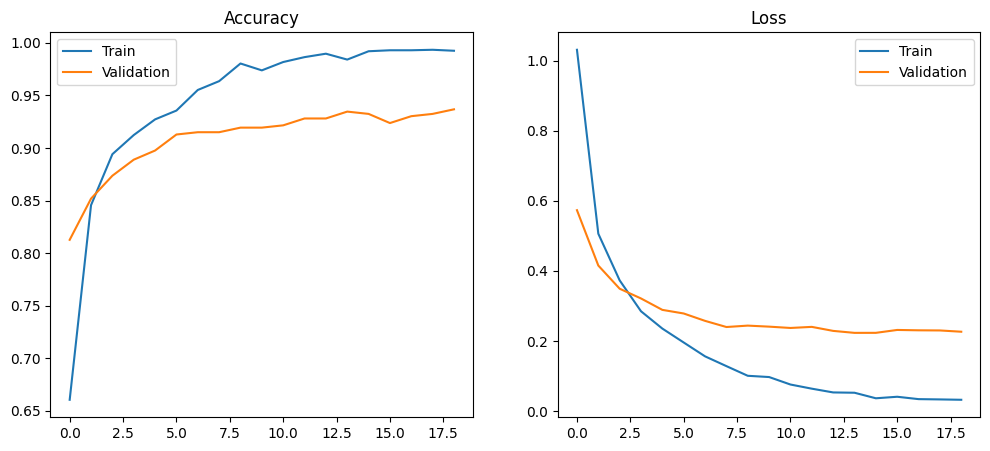

In [ ]:
# Plot training history
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Validation'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Validation'])

plt.show()


In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.9229 - loss: 0.2170
Test Accuracy: 0.936956524848938
Test Loss: 0.20490872859954834


29/29 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step


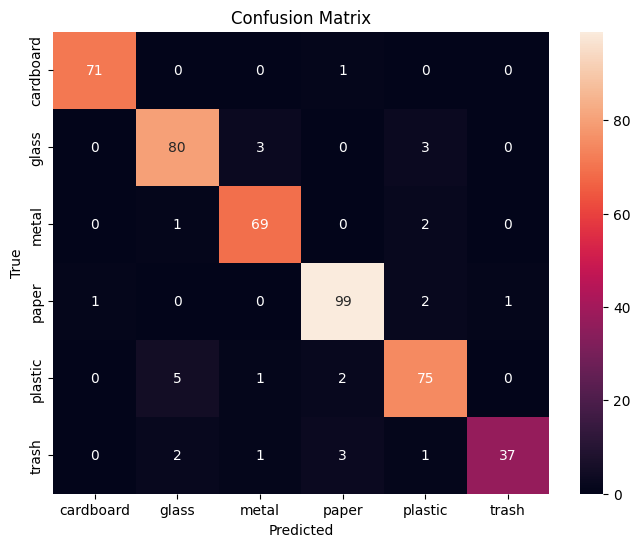

              precision    recall  f1-score   support

   cardboard       0.99      0.99      0.99        72
       glass       0.91      0.93      0.92        86
       metal       0.93      0.96      0.95        72
       paper       0.94      0.96      0.95       103
     plastic       0.90      0.90      0.90        83
       trash       0.97      0.84      0.90        44

    accuracy                           0.94       460
   macro avg       0.94      0.93      0.93       460
weighted avg       0.94      0.94      0.94       460



In [ ]:
# Show detailed metrics
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
labels = list(train_generator.class_indices.keys())

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))

In [ ]:
def predict_single(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)

    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    return class_labels[class_idx], prediction[0][class_idx]


predict_single("/content/drive/MyDrive/dataset-final/glass/glass105.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


('glass', np.float32(0.99954504))